In [ ]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd

# Data

In [1]:
positive_sentences = open('data/positive.txt', 'r')
negative_sentences = open('data/negative.txt', 'r')
positive_list = [line.replace('\n', '') for line in positive_sentences.readlines()]
negative_list = [line.replace('\n', '') for line in negative_sentences.readlines()]

positive_list[:5]

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal . ',
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle earth . ',
 'effective but too tepid biopic',
 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start . ',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one . "]

In [2]:
positive_df = pd.DataFrame({'sentences':positive_list})
positive_df['feeling'] = 1
negative_df = pd.DataFrame({'sentences':negative_list})
negative_df['feeling'] = 0

In [3]:
data = pd.concat([positive_df, negative_df])
# lower case
data['sentences'] = data['sentences'].str.lower()
# shuffle
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,sentences,feeling
0,"a venturesome , beautifully realized psycholog...",1
1,"[e]ventually , every idea in this film is flus...",0
2,"thought provoking and stylish , if also somewh...",1
3,"some writer dude , i think his name was , uh ,...",0
4,don't waste your money .,0
5,not one moment in the enterprise didn't make m...,0
6,"you see robin williams and psycho killer , and...",0
7,majidi gets uniformly engaging performances fr...,1
8,"an enthralling , playful film that constantly ...",1
9,woo's fights have a distinct flair . his warri...,1


In [4]:
import string
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation.replace("'",''))])
    return s
# remove ponctuation except "'"
data['sentences'] = data['sentences'].apply(remove_punctuation)
data.head(10)

,sentences,feeling
0,a venturesome beautifully realized psychologi...,1
1,eventually every idea in this film is flushed...,0
2,thought provoking and stylish if also somewha...,1
3,some writer dude i think his name was uh mi...,0
4,don't waste your money,0
5,not one moment in the enterprise didn't make m...,0
6,you see robin williams and psycho killer and ...,0
7,majidi gets uniformly engaging performances fr...,1
8,an enthralling playful film that constantly f...,1
9,woo's fights have a distinct flair his warrio...,1


In [5]:
# tokenize
tokens = [ s.split() for s in data['sentences']]
len(tokens)

10662

In [6]:
tokens[0]

['a',
 'venturesome',
 'beautifully',
 'realized',
 'psychological',
 'mood',
 'piece',
 'that',
 'reveals',
 'its',
 'first',
 'time',
 'feature',
 "director's",
 'understanding',
 'of',
 'the',
 'expressive',
 'power',
 'of',
 'the',
 'camera']

# Word vector

In [16]:
import gensim.downloader as api
from gensim.models import KeyedVectors

NEED_DOWNLOAD = False
if NEED_DOWNLOAD:
    word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    word_vectors.save('data/glove-wiki-gigaword-100.bin')
else:
    word_vectors = KeyedVectors.load('data/glove-wiki-gigaword-100.bin')  


In [17]:
word_vectors.most_similar(positive=['paris', 'germany'], negative=['france'])

[('berlin', 0.8846380710601807),
 ('frankfurt', 0.7985544204711914),
 ('vienna', 0.76759934425354),
 ('munich', 0.7542588710784912),
 ('hamburg', 0.718237042427063),
 ('bonn', 0.6890878677368164),
 ('prague', 0.6842441558837891),
 ('cologne', 0.6762093305587769),
 ('zurich', 0.6653269529342651),
 ('leipzig', 0.6619254350662231)]

In [18]:
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


C:\Users\antho\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [19]:
word_vectors.similarity('woman', 'man')

0.8323494

# Prepare data

max length is: 51


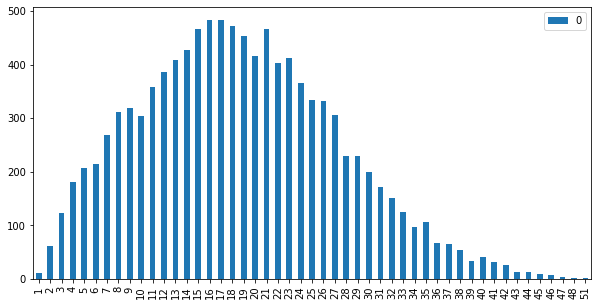

In [24]:
# display distribution of the sentences' sizes
import pandas
from collections import Counter

sizes = [len(el) for el in tokens]
sizes_counts = Counter(sizes)
df = pandas.DataFrame.from_dict(dict(sorted(sizes_counts.items())), orient='index')

df.plot(kind='bar', figsize=(10,5));
print('max length is:', max(sizes_counts, key=int))

In [25]:
from tqdm import tqdm

keys = word_vectors.vocab.keys()
vocabIndex = {}
for w in keys:
	vocabIndex[w] = word_vectors.vocab[w].index

X = []
y = []
MAX_LENGTH = max(sizes_counts, key=int)
WORD_EMBEDDING_DIM = 100

for el in tqdm(tokens):
    row = np.zeros((MAX_LENGTH, WORD_EMBEDDING_DIM))
    words = el
    for j in range(min(MAX_LENGTH, len(words))):
        if words[j] in word_vectors.vocab:
            indexVal = vocabIndex[words[j]]
            row[j] = word_vectors[words[j]]
    X.append(row)
	
X = np.asarray(X)
y = np.asarray(data['feeling'].values)

print('X shape:', X.shape, ', Y shape:', y.shape)

100%|██████████| 10662/10662 [00:00<00:00, 15937.48it/s]


X shape: (10662, 51, 100) , Y shape: (10662,)


In [184]:
X[0], y

(array([[ 0.60074002,  0.324     ,  0.72399998, ..., -0.64135998,
         -0.086523  , -0.13375001],
        [ 0.41600001,  0.16817001,  0.29594001, ..., -0.37358999,
         -0.0084974 ,  0.50651002],
        [-0.54263997,  0.41475999,  1.03219998, ..., -1.29690003,
          0.76217002,  0.46349001],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([1, 0, 0, ..., 1, 1, 0], dtype=int64))

In [26]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
assert abs(y.shape[0]*TEST_SIZE - y_test.shape[0]) < 1
assert abs(X.shape[0]*TEST_SIZE - X_test.shape[0]) < 1

# Model

In [215]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SpatialDropout1D, Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.layers.embeddings import Embedding

model = Sequential()
#model.add(Embedding(TOP_WORDS, 100, input_length=MAX_LENGTH))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same',
                        activation='relu',
                        input_shape=(MAX_LENGTH, WORD_EMBEDDING_DIM)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(51, 100), filters=32, kernel_size=3, padding="same")`
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 51, 32)            9632      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 36,577
Trainable params: 36,577
Non-trainable params: 0
_________________________________________________________________


In [216]:
from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback

class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.accuracy = []
        self.val_f1s = []
        self.val_acc = []
        self.train_acc = []
        self.train_f1s = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.round(self.model.predict(self.validation_data[0]))
        _val_f1 = f1_score(self.validation_data[1], val_predict)
        _val_acc = accuracy_score(self.validation_data[1], val_predict)
        train_predict = np.round(self.model.predict(X_train))
        _train_f1 = f1_score(y_train, train_predict)
        _train_acc = accuracy_score(y_train, train_predict)
        self.val_f1s.append(_val_f1)
        self.val_acc.append(_val_acc)
        self.train_acc.append(_train_f1)
        self.train_f1s.append(_train_acc)
        print("Train F1 : {:2.2f}% - Accuracy : {:2.2f}%".format(_train_f1 * 100, _train_acc * 100))
        print("Test F1 : {:2.2f}% - Accuracy : {:2.2f}%".format(_val_f1 * 100, _val_acc * 100))
        return

metrics = Metrics()

model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=2, validation_data=(X_test, y_test), callbacks=[metrics])

Train on 7463 samples, validate on 3199 samples
Epoch 1/20
 - 4s - loss: 0.6842 - accuracy: 0.5554 - val_loss: 0.7611 - val_accuracy: 0.6008
Train F1 : 70.81% - Accuracy : 61.88%
Test F1 : 69.46% - Accuracy : 60.08%
Epoch 2/20
 - 3s - loss: 0.6031 - accuracy: 0.6938 - val_loss: 0.5986 - val_accuracy: 0.6852
Train F1 : 59.54% - Accuracy : 69.21%
Test F1 : 57.20% - Accuracy : 68.52%
Epoch 3/20
 - 3s - loss: 0.5531 - accuracy: 0.7300 - val_loss: 0.5321 - val_accuracy: 0.7399
Train F1 : 74.29% - Accuracy : 76.19%
Test F1 : 71.72% - Accuracy : 73.99%
Epoch 4/20
 - 3s - loss: 0.5304 - accuracy: 0.7445 - val_loss: 0.5076 - val_accuracy: 0.7471
Train F1 : 78.86% - Accuracy : 78.74%
Test F1 : 74.74% - Accuracy : 74.71%
Epoch 5/20
 - 3s - loss: 0.5062 - accuracy: 0.7611 - val_loss: 0.4979 - val_accuracy: 0.7571
Train F1 : 79.23% - Accuracy : 79.70%
Test F1 : 74.96% - Accuracy : 75.71%
Epoch 6/20
 - 3s - loss: 0.4793 - accuracy: 0.7790 - val_loss: 0.5044 - val_accuracy: 0.7537
Train F1 : 81.56% -

In [218]:
# saving model
if True:
    model_json = model.to_json()
    with open("models/simple_model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("models/simple_model.h5")

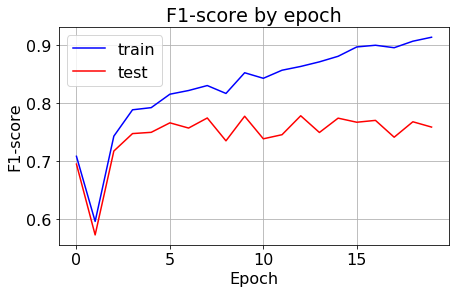

In [223]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import seaborn as sns

plt.figure(figsize=(7,4))
sns.lineplot(range(20), metrics.train_acc, color="blue", label="train")
sns.lineplot(range(20), metrics.val_f1s, color="red", label="test")
plt.title("F1-score by epoch")
plt.ylabel("F1-score")
plt.xlabel("Epoch")
plt.grid()
plt.show()

# Test

In [20]:
# load model
from keras.models import model_from_json
json_file = open('models/simple_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("models/simple_model.h5")

Using TensorFlow backend.


In [28]:
examples = ["I feel tired, could you please leave?",
            "Please, can you go somewhere else?",
            "Can you go somewhere else?",
            "I would like you to leave this place",
            "I would like you to leave this place now",
            "Leave this place right now before I kick your ass"]

print("This model ranks the kindness of a sentence:")
for i, example in enumerate(examples):
    X_ex = np.zeros((MAX_LENGTH, WORD_EMBEDDING_DIM))
    words = example.split(" ")
    for j in range(min(MAX_LENGTH, len(words))):
        words[j] = words[j].lower()
        if words[j] in word_vectors.vocab:
            indexVal = vocabIndex[words[j]]
            X_ex[j] = word_vectors[words[j]]

    X_ex = np.array([X_ex])
    pred = loaded_model.predict([X_ex])
    print("\t {1:2.2f}% for: {0}".format(example, pred[0][0] * 100))

This model ranks the kindness of a sentence:
	 87.04% for: I feel tired, could you please leave?
	 67.65% for: Please, can you go somewhere else?
	 56.23% for: Can you go somewhere else?
	 40.14% for: I would like you to leave this place
	 22.84% for: I would like you to leave this place now
	 18.99% for: Leave this place right now before I kick your ass
